# BASICS 03 - HOTS with online classification (Grimaldi et al. 2022)

In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
import tqdm
print(f'Tonic version installed -> {tqdm.__version__}')

Tonic version installed -> 4.62.3


In [13]:
%cd ../hots
import tonic, torch, os, pickle
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [14]:
type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset)
num_sample_train = len(loader)
num_sample_test = len(testset)
print(f'number of samples in the training set: {len(loader)}')

  0%|          | 0/700096 [00:00<?, ?it/s]

Extracting ../../Data/POKERDVS/pips_train.tar.gz to ../../Data/POKERDVS


  0%|          | 0/311022 [00:00<?, ?it/s]

Extracting ../../Data/POKERDVS/pips_test.tar.gz to ../../Data/POKERDVS
number of samples in the training set: 48


## Initialization of the network

In [4]:
name = 'homeohots'
homeo = True
timestr = '2022-05-11'
dataset_name = 'poker'
n_classes = len(trainset.classes)

Rz = [2, 4]
N_neuronz = [8, 16]
tauz = [1e3, 4e3]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

initial_name = hots.name

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False)

initial_name_nohomeo = hots_nohomeo.name

device -> cuda
device -> cuda


## Unsupervised clustering

In [5]:
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering)
path_nohomeo = '../Records/networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering)

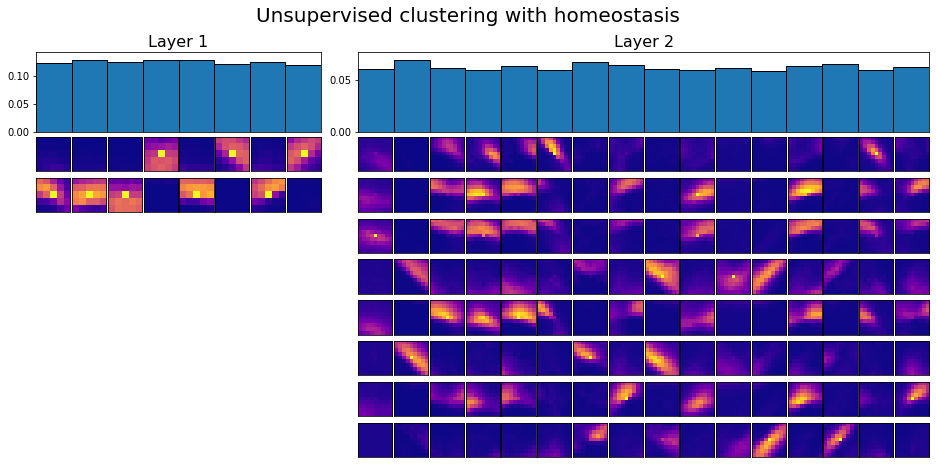

In [12]:
fig = hots.plotlayers()

In [13]:
from utils import printfig
printfig(fig, 'layerwiz.pdf')

## Training of the classification layer

In [6]:
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 2e4

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
trainloader = get_loader(trainset_output)
classif_layer, losses = fit_mlr(trainloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

hots_nohomeo.coding(loader, trainset.ordering, trainset.classes, training=True)

train_path_nohomeo = f'../Records/output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
model_path_nohomeo = f'../Records/networks/{hots_nohomeo.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
trainloader_nohomeo = get_loader(trainset_output_nohomeo)
classif_layer_nohomeo, losses_nohomeo = fit_mlr(trainloader_nohomeo, model_path_nohomeo, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-27_poker_homeohots_False_[8, 16]_[1000.0, 4000.0]_[2, 4]_48_(None, None)/


this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-27_poker_homeohots_False_[8, 16]_[1000.0, 4000.0]_[2, 4]_20_(None, None)/
Mean accuracy: 98.3%
last accuracy: 100.0%


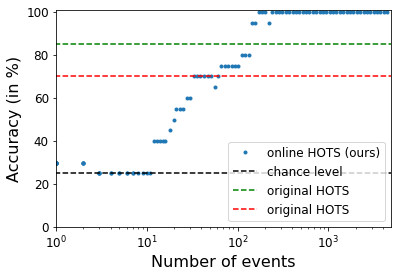

In [7]:
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

testset_output = HOTS_Dataset(test_path, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
testloader = get_loader(testset_output)

loader = get_loader(testset)
hots_nohomeo.coding(loader, trainset.ordering, trainset.classes, training=False)

test_path_nohomeo = f'../Records/output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'
testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)

if not os.path.exists('../Records/LR_results/'):
    os.mkdir('../Records/LR_results/')

likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,testloader,results_path,ts_size,testset_output.ordering)
score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
score_nohomeo = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_neuronz[-1])
meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, figure_name = 'poker_online.pdf')
print(f'last accuracy: {lastac*100}%')